# Load Model

load the segmentation model

In [6]:
# Connect to gdrive and copy the model over
from google.colab import drive
drive.mount('/gdrive')


# !cp -r "/gdrive/MyDrive/traina/classification/12_6/" full_images




Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
!cp "/gdrive/My Drive/traina/segmentation/seg_model_12_15_2022.pt" segmentation_model.pt

In [10]:
!cp "/gdrive/MyDrive/traina/classification/threetypes_filtered.zip" three_types.zip

import zipfile
import io
zf = zipfile.ZipFile('three_types.zip', "r")
zf.extractall('three_types')

KeyboardInterrupt: ignored

In [12]:
!cp "/gdrive/MyDrive/traina/newlights/aligned.zip" aligned.zip

import zipfile
import io
zf = zipfile.ZipFile('aligned.zip', "r")
zf.extractall('aligned')

In [13]:
import torchvision

# model definition

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=False,
        num_classes=2,

        # base class MaskR-CNN parameters
        # transform parameters
        min_size=800,
        max_size=1232,
        image_mean=None,
        image_std=None,
        # RPN parameters
        rpn_anchor_generator=None,
        rpn_head=None,
        rpn_pre_nms_top_n_train=20000,
        rpn_pre_nms_top_n_test=10000,
        rpn_post_nms_top_n_train=20000,
        rpn_post_nms_top_n_test=10000,
        rpn_nms_thresh=0.7,
        rpn_fg_iou_thresh=0.7,
        rpn_bg_iou_thresh=0.3,
        rpn_batch_size_per_image=256,
        rpn_positive_fraction=0.5,
        rpn_score_thresh=0.0,
        # Box parameters
        box_roi_pool=None,
        box_head=None,
        box_predictor=None,
        box_score_thresh=0.05,
        box_nms_thresh=0.5,
        box_detections_per_img=1000,
        box_fg_iou_thresh=0.5,
        box_bg_iou_thresh=0.5,
        box_batch_size_per_image=5120,
        box_positive_fraction=0.25,
        bbox_reg_weights=None,
        # Mask parameters
        mask_roi_pool=None,
        mask_head=None,
        mask_predictor=None,

    )

    return model


In [14]:
import torch

model_weights = torch.load('segmentation_model.pt')

model = get_instance_segmentation_model(2)

model.load_state_dict(model_weights)
model.to('cuda')
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1232, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [15]:
import os
from PIL import Image
import torchvision.transforms.functional as TF

from collections.abc import Sequence

class ImageData(Sequence):
  def __init__(self, root):
    self.image_files = os.listdir(root)
    self.root = root

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    path = os.path.join(self.root, self.image_files[idx])
    image = Image.open(path)
    tensor = TF.to_tensor(image)
    #tensor = tensor / 255.0

    # TO DO: adjust crop size
    #tensor = TF.crop(tensor, 150, 75,400,2200)
    return tensor



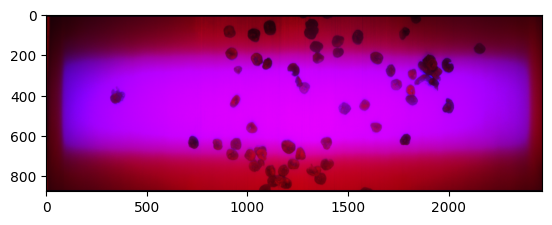

In [17]:
cleans = ImageData("/content/aligned/aligned/20231214_natural_clean_40hz_150mm")
#cleans[0].shape
#cleans[0]

import matplotlib.pyplot as plt

plt.imshow(  cleans[0].permute(1, 2, 0)  )

In [18]:
with torch.no_grad():
  prediction = model(cleans[0].unsqueeze(0).to('cuda'))
  prediction = prediction[0]

In [19]:
prediction

{'boxes': tensor([[ 316.9914,  365.9143,  391.4033,  445.5079],
         [1966.4155,  414.7776, 2029.3345,  493.2236],
         [ 703.7598,  601.0723,  761.6026,  668.6938],
         [1961.5580,  212.8460, 2027.9240,  293.4599],
         [1449.7865,  432.2717, 1518.3883,  500.4752],
         [1278.3315,   21.4652, 1356.0137,  130.3011],
         [1164.7656,  618.2176, 1241.5681,  696.4600],
         [1360.6842,  604.6308, 1424.4608,  671.6489],
         [1607.4749,  182.5166, 1678.2651,  251.9477],
         [1607.2482,  531.7759, 1672.3141,  590.6476],
         [1551.1631,  417.5169, 1614.7742,  483.5301],
         [ 908.3320,  395.7940,  968.8595,  468.6187],
         [ 822.2901,  613.1234,  882.8651,  676.9509],
         [1851.1090,  197.0621, 1957.9095,  307.9720],
         [1756.3589,  590.2064, 1813.5908,  650.6943],
         [ 989.2811,  529.4077, 1056.3687,  594.6525],
         [2123.6694,  139.8221, 2184.5327,  200.8580],
         [1360.9164,  712.0778, 1432.8209,  777.7537],
 

In [20]:
from torchvision.utils import draw_bounding_boxes
toPil = torchvision.transforms.ToPILImage()


def create_bbox_image(img_raw, prediction):

  boxes = prediction['boxes']
  scores = prediction['scores']
  masks = prediction['masks']

  valid_boxes = boxes[scores > 0.5]
  valid_masks = masks[scores > 0.5]

  image_uint8 = img_raw * 255
  image_uint8 = image_uint8.type(torch.uint8)

  img = draw_bounding_boxes(image_uint8, valid_boxes, width = 1)

  #plt.imshow(  img.permute(1, 2, 0)  )

  img_pil = toPil(img)

  return img_pil



img_pil_bbox = create_bbox_image(cleans[0], prediction)

img_pil_bbox

Output hidden; open in https://colab.research.google.com to view.

In [21]:
# kernel used for dialate - erode image processing
import numpy as np

# kernel = np.array([ [1, 1, 1, 1, 1],
#                     [1, 1, 1, 1, 1],
#                     [1, 1, 1, 1, 1],
#                     [1, 1, 1, 1, 1],
#                     [1, 1, 1, 1, 1] ], dtype=np.float32)
kernel = np.array([ [1, 1, 1],
                    [1, 1, 1],
                    [1, 1, 1] ], dtype=np.float32)

kernel_tensor = torch.tensor(np.expand_dims(np.expand_dims(kernel, 0), 0),  device='cpu') # size: (1, 1, 5, 5)

def dialate_erode(mask):

  #print(mask.shape)
  mask = torch.clamp(torch.nn.functional.conv2d(mask, kernel_tensor), 0, 1) # , padding=(1, 1)
  mask = 1 - mask
  mask = torch.clamp(torch.nn.functional.conv2d(mask, kernel_tensor), 0, 1) # , padding=(1, 1)
  mask = 1 - mask
  #print(mask.shape)
  return mask

In [22]:
# get the individual images
img_raw = cleans[0]

crop = torchvision.transforms.CenterCrop(128)

def get_individual(img, box, mask):
  x1 = int(box[0])
  y1 = int(box[1])
  x2 = int(box[2])
  y2 = int(box[3])



  #print(img_raw.shape)
  img_individual = img[:,y1:y2,x1:x2]
  img_individual = crop(img_individual)


  mask_individual = mask[:,y1:y2,x1:x2]
  mask_individual = crop(mask_individual)


  mask_individual_cpu = mask_individual.cpu()
  # mask_individual_cpu = dialate_erode(mask_individual_cpu)
  # mask_individual_cpu = crop(mask_individual_cpu)
  masked_individual = img_individual * mask_individual_cpu


  # TO DO: process mask with expand - shrink

  # masked_individual = crop(masked_individual)

  #print(masked_individual.shape)

  #plt.imshow(  masked_individual.permute(1, 2, 0)  )

  return masked_individual,mask_individual

In [23]:

def save_individuals(img, prediction, prefix, folder):

  boxes = prediction['boxes']
  scores = prediction['scores']
  masks = prediction['masks']

  mask_left = (boxes[:,0]).ge(50)
  mask_right = (boxes[:,2]).le(2400)
  mask_top = (boxes[:,1]).ge(175)
  mask_bot = (boxes[:,3]).le(725)

  mask_x = torch.logical_and(mask_left, mask_right)
  mask_y = torch.logical_and(mask_top, mask_bot)

  mask_xy = torch.logical_and(mask_x, mask_y)

  mask_scores = scores.ge(0.5)

  mask_all = torch.logical_and(mask_xy, mask_scores)

  valid_boxes = boxes[mask_all]
  valid_masks = masks[mask_all]

  image_uint8 = img * 255
  image_uint8 = image_uint8.type(torch.uint8)

  for argi in range(0, len(valid_boxes)):
    img_tensor = get_individual( img, valid_boxes[argi], valid_masks[argi])
    # print(img_tensor[0])
    img_pil = toPil(img_tensor[0])

    name = f'{prefix}_{argi}.png'
    path = os.path.join(folder, name)

    folder

    img_pil.save(path)

!mkdir -p test
save_individuals(img_raw, prediction, 'test_1', 'test')

In [24]:
# define a function to process all the image in folder
def process_folder(folder, class_id):

  save_folder = f'individuals/{class_id}'
  bbox_folder = f'boxes/{class_id}'
  if not os.path.isdir(save_folder):
    os.makedirs(save_folder)
  if not os.path.isdir(bbox_folder):
    os.makedirs(bbox_folder)

  images = ImageData(folder)

  with torch.no_grad():


    for index, img in enumerate(images):
      prediction = model(img.unsqueeze(0).to('cuda'))
      prediction = prediction[0]

      prefix = f'{class_id}_{index}'

      save_individuals(img, prediction, prefix, save_folder)

      bbox_path = os.path.join(bbox_folder, f'{class_id}_bbox_{index}.png')
      img_pil_bbox = create_bbox_image(img, prediction)
      img_pil_bbox.save(bbox_path)



In [25]:
# create test folder

!mkdir -p full_images/test
!cp '/content/three_types/threetypes_filtered/clean natural/image_20230323T150135.png' full_images/test/image_20230323T150135.png


In [26]:

images = ImageData('full_images/test')

img = images[0]

with torch.no_grad():
  prediction = model(img.unsqueeze(0).to('cuda'))
  prediction = prediction[0]

prediction

{'boxes': tensor([[1561.0010,  382.6075, 1649.6792,  452.4749],
         [ 626.3243,  582.0740,  705.9538,  670.0266],
         [1321.8114,  366.7694, 1380.2911,  434.5196],
         [ 922.8397,   45.5287, 1001.6705,  141.1668],
         [1128.2847,  327.4092, 1192.6641,  395.3286],
         [ 720.0796,  122.7518,  838.3076,  238.9497],
         [ 806.6891,  258.9231,  870.3855,  343.4493],
         [ 698.2637,  504.8128,  766.9659,  573.0071],
         [1371.4291,  511.5433, 1433.2831,  580.1139],
         [ 972.8918,  179.0525, 1037.5994,  246.6156],
         [ 595.3801,  387.9375,  664.4755,  445.3998],
         [1293.8091,  703.5554, 1362.3323,  771.2432],
         [ 893.2337,  370.2913,  955.0329,  431.4740],
         [ 567.3298,  135.4136,  628.9437,  194.8835],
         [1437.0422,  696.5148, 1498.3601,  767.0247],
         [1080.0385,  825.2667, 1155.8427,  874.9637],
         [1089.1874,  585.6473, 1158.0475,  645.9122],
         [ 875.6652,  509.1911,  927.4454,  565.7009],
 

torch.Size([1, 876, 2464])


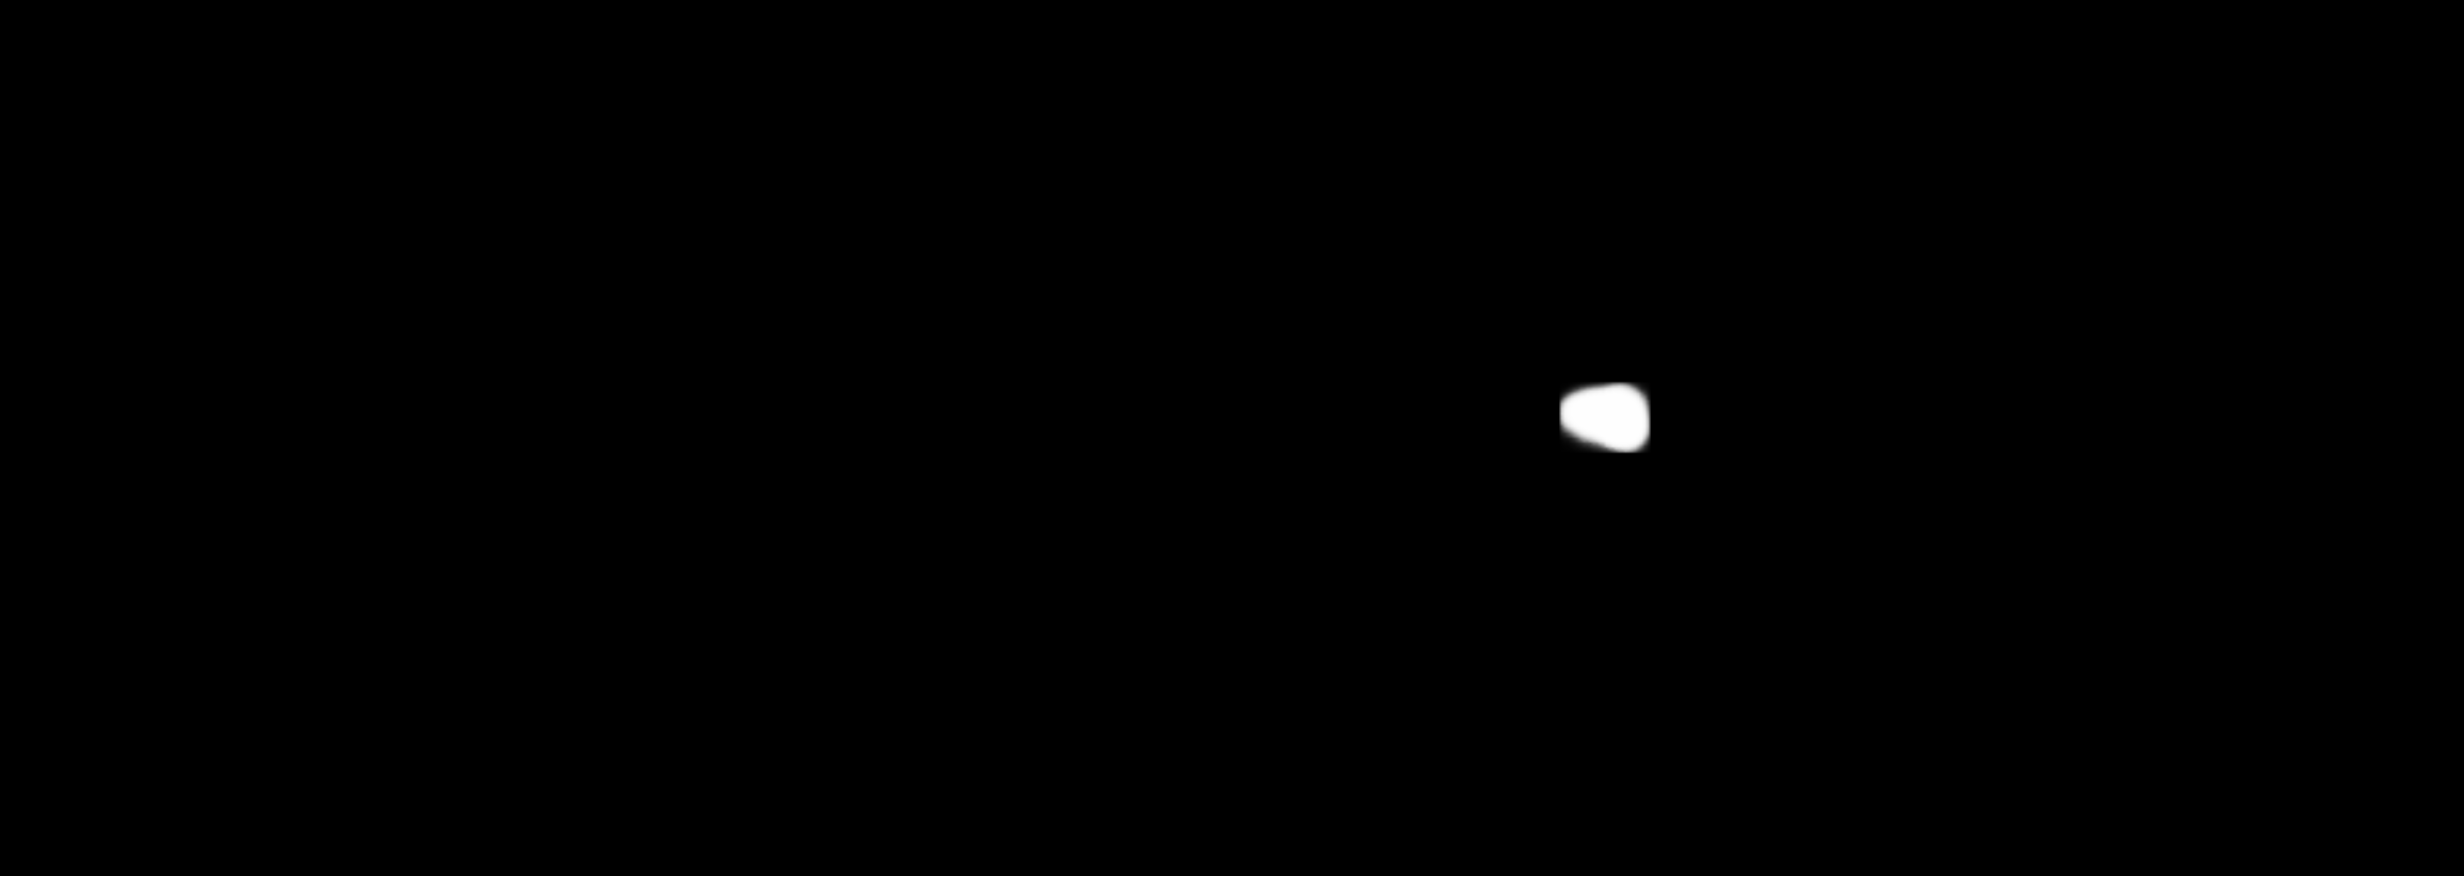

In [27]:
masks = prediction['masks']
mask = masks[0]
mask = mask.cpu()
#mask = mask.numpy()
print(mask.shape)
mask_pil = toPil(mask)
mask_pil

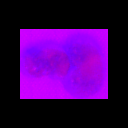

In [28]:
boxes = prediction['boxes']
box = boxes[0]

x1 = int(box[0])
y1 = int(box[1])
x2 = int(box[2])
y2 = int(box[3])


img_individual = img[:,y1:y2,x1:x2]
img_individual = crop(img_individual)


img_individual_pil = toPil(img_individual)
img_individual_pil

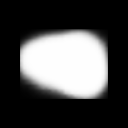

In [29]:

mask_individual = mask[:,y1:y2,x1:x2]
mask_individual = crop(mask_individual)
mask_individual_cpu = mask_individual.cpu()


mask_individual_pil = toPil(mask_individual_cpu)
mask_individual_pil

torch.Size([1, 128, 128])


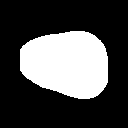

In [30]:
mask_binary = mask_individual.ge(0.5)
# mask_binary = mask_binary.squeeze()

mask_binary = mask_binary * 1.0

print(mask_binary.shape)

mkas_binary_pil = toPil(mask_binary)
mkas_binary_pil

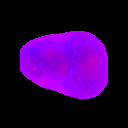

In [31]:
masked = mask_binary * img_individual

masked_pil = toPil(masked)
masked_pil

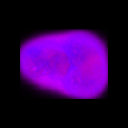

In [32]:
masked = mask_individual * img_individual

masked_pil = toPil(masked)
masked_pil

In [33]:
from pycocotools import mask as m

#print(masks.cpu().numpy())
print(masks.shape)
mask_transposed = mask.permute(1,2,0)

mask_numpy =  mask_transposed.ge(0.5).numpy()
#mask_numpy = mask_individual.numpy() # mask_individual.ge(0.5).numpy()
mask_numpy = mask_numpy.astype(np.uint8)
#print(mask_numpy)

fortran_ground_truth_binary_mask = np.asfortranarray(mask_numpy)

encoded = m.encode(fortran_ground_truth_binary_mask)
print(encoded)

decoded = m.decode(encoded)
decoded

torch.Size([36, 1, 876, 2464])
[{'size': [876, 2464], 'counts': b'nhgY1f0ej02M4M2O1N2N2N2O0O2N101O1N2O0O2O001N101O1N101O000O101O00000O2O00001O0000001O0O2O00001O001N10001O000O2O0000001O0000001O000000000001O0000001O0O2O001O0O2O1N2O1N2N1O3M2N2N3L4M5J6Jmihe0'}]


array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

In [34]:
process_folder('full_images/test', 'test')

In [35]:
# copy data back to drive

# !cp -r  individuals "/gdrive/MyDrive/traina/classification/data_12_6/individuals"
# !cp -r  boxes "/gdrive/MyDrive/traina/classification/data_12_6/boxes"

In [36]:
process_folder('/content/aligned/aligned/20231214_natural_clean_40hz_150mm', 'natural_clean')
process_folder('/content/aligned/aligned/20231214_naural_pits_40hz_150mm', 'natural_with_pits')
process_folder('/content/aligned/aligned/20231214_organic_clean_40hz_150mm_trigger', 'organic_clean')
process_folder('/content/aligned/aligned/20231214_organic_pits_40hz', 'organic_pits')
process_folder('/content/aligned/aligned/20231214_so_clean_40hz_150mm', 'sulfer_clean')
process_folder('/content/aligned/aligned/20231214_so_pits_40hz_150', 'sulfer_pits')

In [67]:
!cp -r /content/individuals /content/drive/MyDrive/traina/classification/newLightSingles


In [39]:
# we will combine all data together and train to get a baseline.
# we could have different algorithms for each cherry type, but that means we need to add a way to switch between the algorithms - aka more work.
# it also means the wrong algorithm could get used accidentally.

if not os.path.exists('data/'):
  os.mkdir('data/')
if not os.path.exists('data/pit/'):
  os.mkdir('data/pit/')
if not os.path.exists('data/clean/'):
  os.mkdir('data/clean/')

import glob
import shutil

cleans = [
    'natural_clean',    # accidentally left a space in this folder name before I ziped it up, shouldn;t make a difference, but may correct at some point.
    'organic_clean',
    'sulfer_clean',
]

pits = [
    'natural_with_pits',
    'organic_pits',
    'sulfer_pits',
]

for pFolder in pits:
  src_dir = 'individuals/{0}'.format(pFolder)
  dst_dir = "data/pit"
  for imgFile in glob.iglob(os.path.join(src_dir, "*")):
    shutil.copy(imgFile, dst_dir)

for pFolder in cleans:
  src_dir = 'individuals/{0}'.format(pFolder)
  dst_dir = "data/clean"
  for imgFile in glob.iglob(os.path.join(src_dir, "*")):
    shutil.copy(imgFile, dst_dir)


### create singles dataset

In [40]:
# Data augmentation and normalization for training
# Just normalization for validation

from torchvision import datasets, models
import torchvision.transforms.v2 as tf
import torch

from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

data_transforms = {
    'train': tf.Compose([
        #transforms.CenterCrop(128),
        #transforms.RandomAffine(degrees=(0, 20), translate=(0, 0), scale=(0.85, 1.15)),
        # tf.RandomRotated(   180   ),
        tf.RandomHorizontalFlip(),
        tf.RandomVerticalFlip(),
        tf.RandomResizedCrop(size=(90, 90)),
        # transforms.RandomPosterize(bits = 2),
        # transforms.RandomAdjustSharpness(sharpness_factor=2),
        # transforms.RandomAutocontrast(),
        # transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        tf.ToTensor(),
        # transforms.Normalize([0.5, 0, 0.5], [0.25, 1, 0.25])
    ]),
    'val': tf.Compose([
        #transforms.CenterCrop(128),
        tf.ToTensor(),
        # transforms.Normalize([0.5, 0, 0.5], [0.25, 1, 0.25])
    ]),
}

data_dir = 'data'
image_dataset = { x : datasets.ImageFolder(data_dir, data_transforms[x])
                  for x in ['train', 'val']}

validation_split = .2
shuffle_dataset = True
random_seed= 42
batch_size = 100

# Creating data indices for training and validation splits:
dataset_size = len(image_dataset['train'])
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

indices = {
    'train' : train_indices,
    'val' : val_indices,
}
print(len(indices['train']), len(indices['val']))

# # Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)

samplers = {x: SubsetRandomSampler(indices[x]) for x in ['train', 'val']}

# dataloaders = {
#   'train' : torch.utils.data.DataLoader(image_dataset, batch_size=batch_size,
#                                         sampler=train_sampler,
#                                         num_workers=2 ),
#   'val' : torch.utils.data.DataLoader(image_dataset,
#                                       batch_size=batch_size,
#                                       sampler=valid_sampler,
#                                       num_workers=2 ),
# }


dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=batch_size,
                                             sampler=samplers[x], num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_dataset['train'].classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


20453
16363 4090
{'train': 164, 'val': 41}
['clean', 'pit']


In [41]:
im = image_dataset['train'][4000]

im

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.5882, 0.5843, 0.5843],
          [0.0000, 0.0000, 0.0000,  ..., 0.5843, 0.5804, 0.5804],
          [0.0000, 0.0000, 0.0000,  ..., 0.5804, 0.5804, 0.5804],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.6745, 0.6627, 0.6588],
          [0.0000, 0.0000, 0.0000,  ..., 0.6667, 0.6549, 0.6510],
          [0.0000, 0.0000, 0.0000,  ..., 0

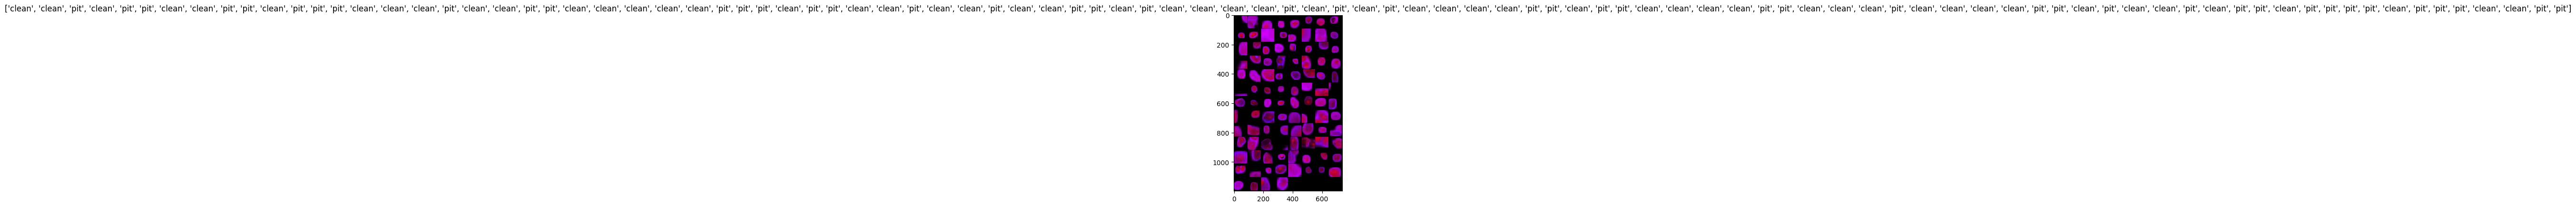

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [42]:
import os
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

out

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [43]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [44]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(outputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [45]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy

model_ft = models.resnet50(pretrained=True)
# model_ft = models.mobilenet_v3_large(num_classes = 2)


num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

#Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# params = model_ft.parameters()
optimizer_ft = optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [46]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 32.7259 Acc: 86.2134
val Loss: 34.2056 Acc: 86.4390

Epoch 1/19
----------
train Loss: 26.6255 Acc: 88.7012
val Loss: 34.5936 Acc: 86.5122

Epoch 2/19
----------
train Loss: 26.5546 Acc: 88.5854
val Loss: 25.0685 Acc: 92.5122

Epoch 3/19
----------
train Loss: 24.6287 Acc: 89.7866
val Loss: 20.4186 Acc: 93.8537

Epoch 4/19
----------
train Loss: 24.2842 Acc: 89.6829
val Loss: 26.0771 Acc: 92.0244

Epoch 5/19
----------
train Loss: 21.5720 Acc: 90.7073
val Loss: 18.4837 Acc: 94.3902

Epoch 6/19
----------
train Loss: 20.8092 Acc: 91.2866
val Loss: 16.9653 Acc: 94.4390

Epoch 7/19
----------
train Loss: 20.3103 Acc: 91.5061
val Loss: 17.4767 Acc: 94.5366

Epoch 8/19
----------
train Loss: 20.3465 Acc: 91.6463
val Loss: 18.6227 Acc: 94.4878

Epoch 9/19
----------
train Loss: 19.5398 Acc: 92.0244
val Loss: 16.3323 Acc: 94.7317

Epoch 10/19
----------
train Loss: 19.6973 Acc: 91.7805
val Loss: 16.8232 Acc: 94.5610

Epoch 11/19
----------
train Loss: 19.0585

tensor([[-1.8525,  1.9097],
        [ 1.3924, -1.4663],
        [-0.2617,  0.2650],
        [-0.3676,  0.3991],
        [ 1.8002, -1.8916],
        [ 0.4839, -0.5075],
        [ 0.8072, -0.8463],
        [ 0.9789, -1.0344],
        [-0.6630,  0.6880],
        [ 1.3189, -1.3855],
        [-2.1018,  2.1101],
        [ 1.2484, -1.2992],
        [ 1.3564, -1.4288],
        [ 1.0765, -1.1342],
        [ 1.8557, -1.9533],
        [-1.1952,  1.2753],
        [ 0.2658, -0.2758],
        [ 1.1101, -1.1584],
        [ 1.8023, -1.8698],
        [ 0.9625, -1.0138],
        [-1.1345,  1.1890],
        [ 0.2245, -0.2341],
        [ 2.1250, -2.2313],
        [ 0.0540, -0.0370],
        [ 2.4667, -2.5784],
        [ 2.4568, -2.6086],
        [-0.7261,  0.7600],
        [-0.1714,  0.1971],
        [-1.3318,  1.4120],
        [-1.5458,  1.6524],
        [ 1.4293, -1.5067],
        [ 1.6569, -1.7542],
        [-1.6047,  1.7090],
        [ 2.2274, -2.3560],
        [-1.0582,  1.1250],
        [ 1.6181, -1

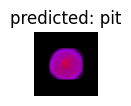

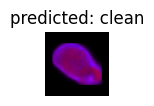

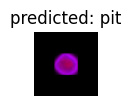

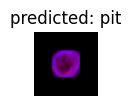

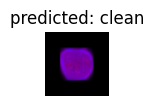

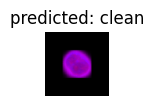

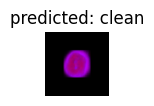

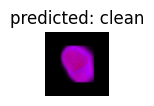

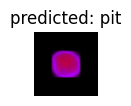

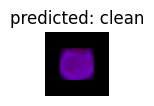

In [47]:
visualize_model(model_ft, num_images=10)

It would be nice to view the dataset with fiftyone, but that is still a work in progress right now

In [69]:
# from google.colab import drive
# drive.mount('/gdrive')

path =  'classification.pt'
torch.save(model_ft.state_dict(), path)

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

filename = 'classification-{0}.pt'.format(timestr)

!cp classification.pt /content/drive/MyDrive/classification-12-15-2023.pt


In [49]:
pip install fiftyone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.1/677.1 kB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (set

In [50]:
import fiftyone as fo
from fiftyone import ViewField as F

Migrating database to v0.23.1


INFO:fiftyone.migrations.runner:Migrating database to v0.23.1


In [51]:

samples = []

def add_to_fiddy(input, label, ouput, pred, conf, confs, img_path, dataset_type):
    global samples

    print(label, ouput, pred, conf, confs, img_path[0])
    sample = fo.Sample(filepath=img_path[0],  tags=[dataset_type])

    classes = ['cherry_clean', 'cherry_pit']

    sample["ground_truth"] = fo.Classification(label=classes[label])
    sample["prediction"] = fo.Classification(label=classes[pred], confidence=conf)

    samples.append(sample)


def evaluate_model(model, num_images=6, dataset_type='val'):

    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    m = nn.Softmax(dim=1)

    with torch.no_grad():

        dl = dataloaders[dataset_type]
        for i, (inputs, labels) in enumerate(dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            images = dl.dataset.imgs[i*100:(i+1)*100]

            #print(inputs)
            outputs = model(inputs)
            confs = m(outputs)
            index, preds = torch.max(confs, 1)



            #print(outputs)

            for j in range(inputs.size()[0]):

                add_to_fiddy(
                    inputs[j].cpu().numpy(),
                    labels[j].cpu().numpy(),
                    outputs[j].cpu().numpy(),
                    preds[j].cpu().numpy(),
                    index[j].cpu().numpy(),
                    confs[j].cpu().numpy(),
                    images[j],
                    dataset_type)

                images_so_far += 1
                # ax = plt.subplot(num_images//2, 2, images_so_far)
                # ax.axis('off')
                # ax.set_title(f'predicted: {class_names[preds[j]]}')
                # imshow(inputs.cpu().data[j])



                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


evaluate_model(model_ft, 10000, dataset_type='val')
evaluate_model(model_ft, 10000, dataset_type='train')



Streaming output truncated to the last 5000 lines.
1 [-2.2051466  2.3198078] 1 0.989281 [0.01071907 0.989281  ] data/clean/organic_clean_33_68.png
1 [-1.8172548  1.8440608] 1 0.9749452 [0.02505481 0.9749452 ] data/clean/organic_clean_33_69.png
1 [ 0.7779402 -0.8226325] 0 0.8320984 [0.8320984  0.16790158] data/clean/organic_clean_33_7.png
0 [ 2.031691  -2.1236873] 0 0.9845622 [0.9845622 0.0154378] data/clean/organic_clean_33_70.png
0 [ 0.6482481  -0.68033814] 0 0.7906067 [0.7906067  0.20939332] data/clean/organic_clean_33_71.png
1 [-7.222796  6.332147] 1 0.9999987 [1.2976647e-06 9.9999869e-01] data/clean/organic_clean_33_72.png
0 [ 0.43137982 -0.47395745] 0 0.7120451 [0.7120451  0.28795493] data/clean/organic_clean_33_73.png
1 [-2.9076133  3.1504295] 1 0.9976665 [0.00233352 0.9976665 ] data/clean/organic_clean_33_74.png
0 [ 1.4913592 -1.5457699] 0 0.9542236 [0.9542236  0.04577641] data/clean/organic_clean_33_75.png
1 [-1.7029964  1.7822702] 1 0.9702656 [0.02973436 0.9702656 ] data/clean

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [53]:
dataset = fo.Dataset("cherry-classification-dataset")
#dataset = fo.load_dataset("cherry-classification-dataset")
dataset.clear()
dataset.add_samples(samples)


 100% |█████████████| 14090/14090 [19.2s elapsed, 0s remaining, 1.7K samples/s]       


INFO:eta.core.utils: 100% |█████████████| 14090/14090 [19.2s elapsed, 0s remaining, 1.7K samples/s]       


['657c177152d520f634677221',
 '657c177152d520f634677222',
 '657c177152d520f634677223',
 '657c177152d520f634677224',
 '657c177152d520f634677225',
 '657c177152d520f634677226',
 '657c177152d520f634677227',
 '657c177152d520f634677228',
 '657c177152d520f634677229',
 '657c177152d520f63467722a',
 '657c177152d520f63467722b',
 '657c177152d520f63467722c',
 '657c177152d520f63467722d',
 '657c177152d520f63467722e',
 '657c177152d520f63467722f',
 '657c177152d520f634677230',
 '657c177152d520f634677231',
 '657c177152d520f634677232',
 '657c177152d520f634677233',
 '657c177152d520f634677234',
 '657c177152d520f634677235',
 '657c177152d520f634677236',
 '657c177152d520f634677237',
 '657c177152d520f634677238',
 '657c177152d520f634677239',
 '657c177152d520f63467723a',
 '657c177152d520f63467723b',
 '657c177152d520f63467723c',
 '657c177152d520f63467723d',
 '657c177152d520f63467723e',
 '657c177152d520f63467723f',
 '657c177152d520f634677240',
 '657c177152d520f634677241',
 '657c177152d520f634677242',
 '657c177152d5

In [54]:

#fo.load_dataset()
fo.close_app()
session = fo.launch_app(dataset)


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.23.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.23.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



In [55]:

# Evaluate the objects in the `predictions` field with respect to the
# objects in the `ground_truth` field
results = dataset.evaluate_classifications(
    "prediction",

)



In [56]:

# # Get the 10 most common classes in the dataset
# counts = dataset.count_values("ground_truth.detections.label")
# classes = sorted(counts, key=counts.get, reverse=True)[:2]

# # Print a classification report for the top-10 classes
# results.print_report(classes=classes)

In [57]:
plot = results.plot_confusion_matrix(classes=['cherry_clean', 'cherry_pit'])
plot.show()

# Connect to session
session.plots.attach(plot)

/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



In [58]:
results.print_report()


              precision    recall  f1-score   support

cherry_clean       0.93      0.96      0.94      8305
  cherry_pit       0.94      0.89      0.92      5785

    accuracy                           0.93     14090
   macro avg       0.93      0.93      0.93     14090
weighted avg       0.93      0.93      0.93     14090



In [59]:
plot.freeze()

In [60]:
# Show most INCORRECT predictions on validation split
session.view = (
    dataset
    .match_tags("val")
    .match(F("predictions.label") != F("ground_truth.label"))
)

In [61]:
VAL_view = (
    dataset
    .match_tags("val")
)


# Evaluate the objects in the `predictions` field with respect to the
# objects in the `ground_truth` field
results = VAL_view.evaluate_classifications(
    "prediction",

)

plot = results.plot_confusion_matrix(classes=['cherry_clean', 'cherry_pit'])
plot.show()

# Connect to session
session.plots.attach(plot)

/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



In [62]:
results.print_report()


              precision    recall  f1-score   support

cherry_clean       0.94      0.98      0.96      2415
  cherry_pit       0.97      0.91      0.94      1675

    accuracy                           0.95      4090
   macro avg       0.95      0.94      0.95      4090
weighted avg       0.95      0.95      0.95      4090



In [63]:
!cp -r /gdrive/MyDrive/traina/test_images test_images

cp: cannot stat '/gdrive/MyDrive/traina/test_images': Transport endpoint is not connected


In [64]:
# get an image with all clean except for 1 pit

# image_file = '/gdrive/MyDrive/traina/test_images/just_one/mostly_clean/2_one_pit2.png'
image_file = '/content/drive/MyDrive/traina/test_images/just_one/mostly_clean/2_one_pit2.png'

# image_file = '/content/images/threetypes_filtered/organic_clean/image_20230323T163804.png'
# image_file = '/content/images/threetypes_filtered/organic_clean/image_20230323T163948.png'
# image_file = '/content/images/threetypes_filtered/sulfer_pits/image_20230323T165112.png'

im_tensor = get_image_as_tensor(image_file)
im_tensor




im_tensor = im_tensor.to('cuda')
prediction = model(im_tensor.unsqueeze(0))

prediction

NameError: ignored

In [ ]:
def get_sub_img(im_tensor, bbox):
  center = [(bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2]
  bbox_100 = [center[0]-50, center[1]-50, center[0]+50, center[1]+50]

  bbox_tensor = im_tensor[:, int(bbox_100[1]):int(bbox_100[3]), int(bbox_100[0]):int(bbox_100[2])]

  return bbox_tensor

def create_singles_test(image_file):

  print (image_file)
  im_tensor = get_image_as_tensor(image_file)
  im_tensor = im_tensor[:, 100:800, :]


  # img_tf = transforms.Compose([
  #       #transforms.CenterCrop(128),
  #       transforms.ToTensor(),
  #       transforms.Normalize([0.5, 0, 0.5], [0.25, 1, 0.25])
  #   ])


  # im_tensor = img_tf(im_tensor)

  im_tensor = im_tensor.to('cuda')

  with torch.no_grad():
      prediction = model(im_tensor.unsqueeze(0))

  prediction = prediction
  boxes = prediction[0]['boxes']
  scores = prediction[0]['scores']

  mask = scores.ge(0.5)

  boxes_masked = boxes[mask]

  # width = boxes[:, 3] - boxes[:, 1]
  # height = boxes[:, 2] - boxes[:, 0]
  # mask_w = torch.logical_or(width.ge(10), width.le(150))
  # mask_h = torch.logical_or(height.ge(10), height.le(150))
  # mask_size = torch.logical_or(mask_w, mask_h)


  mask_left = (boxes_masked[:,0]).ge(50)
  mask_right = (boxes_masked[:,2]).le(2400)
  mask_top = (boxes_masked[:,1]).ge(75)
  mask_bot = (boxes_masked[:,3]).le(650)

  mask_x = torch.logical_and(mask_left, mask_right)
  mask_y = torch.logical_and(mask_top, mask_bot)

  mask_xy = torch.logical_and(mask_x, mask_y)

  boxes_masked = boxes_masked[mask_xy]

  #print(boxes_masked)

  boxes_masked = boxes_masked.to(torch.int64)


  # sub_tensors = [torchvision.transforms.functional.crop(int(im_tensor,bbox[1]),bbox[0],bbox[3]-bbox[1],bbox[2]-bbox[0]) for bbox in boxes_masked]
  sub_tensors = [get_sub_img(im_tensor, bbox) for bbox in boxes_masked]

  sub_tensors = torch.stack(sub_tensors)

  return sub_tensors, boxes_masked

  # for index, bbox in enumerate(boxes_masked):
  #     center = [(bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2]
  #     print(center)
  #     bbox_100 = [center[0]-50, center[1]-50, center[0]+50, center[1]+50]
  #     print(bbox_100)

  #     # shimy the bbox into the valid region if on the edge.
  #     if bbox_100[0] < 0 :
  #         bbox_100[0] = 0
  #         bbox_100[2] = 100
  #     if bbox_100[2] > 2463 :
  #         bbox_100[0] = 2363
  #         bbox_100[2] = 2463
  #     if bbox_100[1] < 0 :
  #         continue
  #     if bbox_100[3] > 500 :
  #         continue

  #     bbox_tensor = im_tensor[:, int(bbox_100[1]):int(bbox_100[3]), int(bbox_100[0]):int(bbox_100[2])]
  #     bbox_tensor = bbox_tensor * 255
  #     bbox_cpu = bbox_tensor.type(torch.uint8)

  #     bbox_cpu = bbox_cpu.to('cpu')
  #     img_cherry = Image.fromarray(bbox_cpu.permute(1, 2, 0).byte().numpy())

  #     file_prefix = img.split('.')[0]

  #     cherry_name = '{}_{}.png'.format(file_prefix, index)

  #     cherry_path = os.path.join(destination_folder, cherry_name )

  #     img_cherry.save(cherry_path)


In [ ]:
img_batch, boxes = create_singles_test(image_file)

boxes[:,1] = boxes[:,1] + 100
boxes[:,3] = boxes[:,3] + 100

img_batch.size()

test_preds = model_ft(img_batch)

In [ ]:
test_preds

m = nn.Softmax(dim=1)

confs = m(test_preds)
index, preds = torch.max(confs, 1)

preds

In [ ]:
from torchvision.utils import draw_bounding_boxes

cleans = preds.eq(0)
pits = preds.eq(1)



clean_boxes = boxes[cleans]
pit_boxes = boxes[pits]

img_unit8 = im_tensor * 255
img_unit8 = img_unit8.to(torch.uint8)
img_boxes = draw_bounding_boxes(image = img_unit8, boxes = clean_boxes, colors = "#00FFFF")
img_boxes = draw_bounding_boxes(image = img_boxes, boxes = pit_boxes, colors = "#FF0000")


Image.fromarray(img_boxes.permute(1, 2, 0).byte().numpy())